In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pickle
from sklearn import metrics
import tensorflow as tf
keras = tf.keras
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle


Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


In [ ]:
#open pkl
with open('sensor_data.pkl', 'rb') as f:
    data = pickle.load(f)
df = pd.DataFrame(data)
df.dropna(inplace = True) 
train_size = int(len(df) * 0.85)
train = df[:train_size]
test = df[train_size:]
uni_data = train['Output'].values
validation = test["Output"].values


In [ ]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 15
train_set = seq2seq_window_dataset(uni_data, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
106/106 [==============================] - 3s 15ms/step - loss: 0.8825 - mse: 6.9267
Epoch 2/200
106/106 [==============================] - 2s 14ms/step - loss: 0.8799 - mse: 6.8329
Epoch 3/200
106/106 [==============================] - 2s 15ms/step - loss: 0.8787 - mse: 6.8644
Epoch 4/200
106/106 [==============================] - 2s 15ms/step - loss: 0.8811 - mse: 6.8686
Epoch 5/200
106/106 [==============================] - 2s 15ms/step - loss: 0.8798 - mse: 6.8316
Epoch 6/200
106/106 [==============================] - 2s 15ms/step - loss: 0.8794 - mse: 6.9011
Epoch 7/200
106/106 [==============================] - 2s 15ms/step - loss: 0.8820 - mse: 6.8733
Epoch 8/200
106/106 [==============================] - 2s 14ms/step - loss: 0.8796 - mse: 6.8878
Epoch 9/200
106/106 [==============================] - 2s 15ms/step - loss: 0.8801 - mse: 6.8927
Epoch 10/200
106/106 [==============================] - 2s 15ms/step - loss: 0.8771 - mse: 6.8024
Epoch 11/200
106/106 [=======

(1e-05, 0.1, 0.0, 1.0)

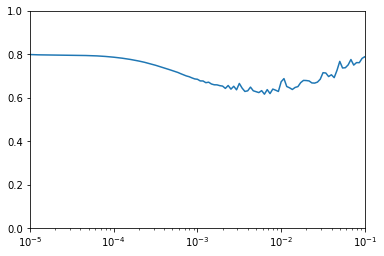

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 1])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 96
train_set = seq2seq_window_dataset(uni_data, window_size,
                                   batch_size=256)
valid_set = seq2seq_window_dataset(validation, window_size,
                                   batch_size=256)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Fully_convolutional_Forecasting.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
53/53 [==============================] - 4s 49ms/step - loss: 0.8821 - mse: 6.7995 - val_loss: 0.5980 - val_mse: 4.9561
Epoch 2/500
53/53 [==============================] - 2s 43ms/step - loss: 0.8785 - mse: 6.7589 - val_loss: 0.5968 - val_mse: 4.9536
Epoch 3/500
53/53 [==============================] - 2s 44ms/step - loss: 0.8758 - mse: 6.7388 - val_loss: 0.5960 - val_mse: 4.9519
Epoch 4/500
53/53 [==============================] - 2s 42ms/step - loss: 0.8751 - mse: 6.7459 - val_loss: 0.5954 - val_mse: 4.9507
Epoch 5/500
53/53 [==============================] - 2s 43ms/step - loss: 0.8762 - mse: 6.7734 - val_loss: 0.5950 - val_mse: 4.9498
Epoch 6/500
53/53 [==============================] - 3s 50ms/step - loss: 0.8740 - mse: 6.7386 - val_loss: 0.5947 - val_mse: 4.9490
Epoch 7/500
53/53 [==============================] - 2s 44ms/step - loss: 0.8754 - mse: 6.7640 - val_loss: 0.5945 - val_mse: 4.9484
Epoch 8/500
53/53 [==============================] - 2s 44ms/step - loss: 0.

In [ ]:
model = keras.models.load_model("Fully_convolutional_Forecasting.h5")

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
cnn_forecast = model_forecast(model, df['Output'].values[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[train_size - window_size:-1, -1, 0]

In [ ]:
cnn_forecast[train_size - window_size:-1,-1,0].shape

(2396,)

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [ ]:
uni_data.shape

(13575,)

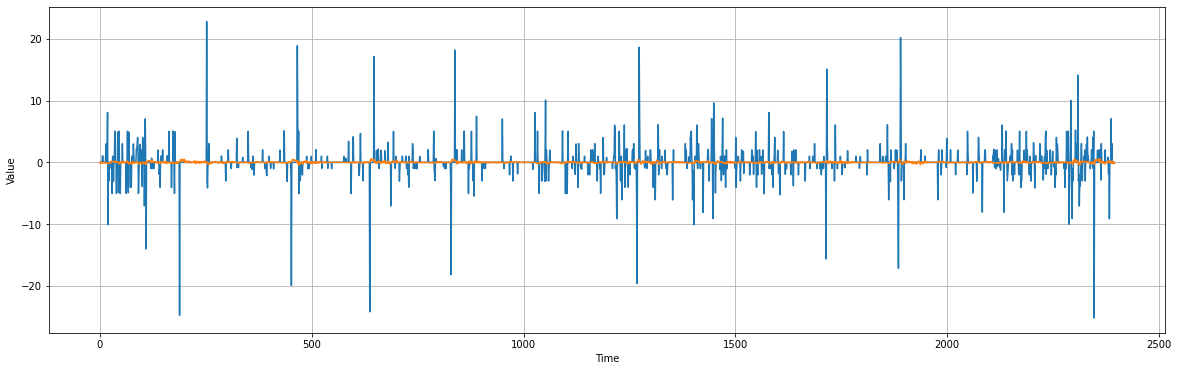

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(range(2396), validation)
plot_series(range(2396), cnn_forecast)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(validation, cnn_forecast)

0.011363181719621807

In [ ]:
(mean_squared_error(validation, np.zeros(2396))-mean_squared_error(validation, cnn_forecast))/mean_squared_error(validation, np.zeros(2396))

0.011364890287441622